## Introduction

The following notebook includes a XGBoost regression to predict total sales for every item and store in the following month (as proposed by the competition: https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/overview/description).

We begin with an **EDA**, followed by **data engineering** focused on pivoting and preparing the data as a timeseries able to be fed into our regression algorithm with both a training and testing period, and lastly we run our **XGBoost regression**, and apply our **prediction** to the testing data.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

In [2]:
item_categories = pd.read_csv (r'C:\Users\t_bor\Anaconda\Projetos\Predict Future Sales\competitive-data-science-predict-future-sales\item_categories.csv')
items = pd.read_csv (r'C:\Users\t_bor\Anaconda\Projetos\Predict Future Sales\competitive-data-science-predict-future-sales\items.csv')
train = pd.read_csv (r'C:\Users\t_bor\Anaconda\Projetos\Predict Future Sales\competitive-data-science-predict-future-sales\sales_train.csv')
shops = pd.read_csv (r'C:\Users\t_bor\Anaconda\Projetos\Predict Future Sales\competitive-data-science-predict-future-sales\shops.csv')
test = pd.read_csv (r'C:\Users\t_bor\Anaconda\Projetos\Predict Future Sales\competitive-data-science-predict-future-sales\test.csv')
sample_submission = pd.read_csv (r'C:\Users\t_bor\Anaconda\Projetos\Predict Future Sales\competitive-data-science-predict-future-sales\sample_submission.csv')

## EDA

In [3]:
#Applying Basic EDA function
def EDA(df):
    return 'First rows', df.head(3),\
    'Info', df.info,\
    'Describe', df.describe(),\
    'Missing Values', df.isnull().sum()

In [4]:
datasets = [item_categories, items, train, shops, test, sample_submission]
#we run the EDA function to all the provided datasets
for i in datasets:
    print(EDA(i))

('First rows',         item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2, 'Info', <bound method DataFrame.info of            item_category_name  item_category_id
0     PC - Гарнитуры/Наушники                 0
1            Аксессуары - PS2                 1
2            Аксессуары - PS3                 2
3            Аксессуары - PS4                 3
4            Аксессуары - PSP                 4
..                        ...               ...
79                  Служебные                79
80         Служебные - Билеты                80
81    Чистые носители (шпиль)                81
82  Чистые носители (штучные)                82
83           Элементы питания                83

[84 rows x 2 columns]>, 'Describe',        item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%    

Looking at the "Describe" table of Train, the minimum values of "item_price" and "item_cnt_day" are negative which doesn't seem to make much logic when we are dealing with Sales. Regarding the maximum values of said features, they are much larger than the mean so we might have outliers here.

[Text(0.5, 1.0, 'item_price has a long tail in the upper values')]

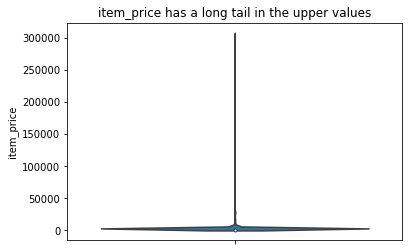

In [5]:
# plot item_price
sns.violinplot(y = train['item_price']).set(title='item_price has a long tail in the upper values')

In [6]:
print(train.sort_values(by=['item_price']).head(5),train.sort_values(by=['item_price']).tail(5))

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973     -1.0000           1.0
608763  08.06.2013               5       58    11865      0.0700           1.0
579766  11.06.2013               5        6    11864      0.0700           1.0
611400  08.06.2013               5       58    20146      0.0875           4.0
673155  31.07.2013               6        6    11872      0.0900           1.0                date  date_block_num  shop_id  item_id  item_price  \
2910156  29.10.2015              33       12    13403     42990.0   
2327159  29.01.2015              24       12     7241     49782.0   
1488135  20.03.2014              14       25    13199     50999.0   
885138   17.09.2013               8       12    11365     59200.0   
1163158  13.12.2013              11       12     6066    307980.0   

         item_cnt_day  
2910156           1.0  
2327159           1.0  
1488135           1.0  
885138         

We clearly have outliers: The last Rows shown above clearly have unusually high "item_price". Row 484683 contains a negative item_price which is not realistic.

[Text(0.5, 1.0, 'item_cnt_day has a long tail in the upper values')]

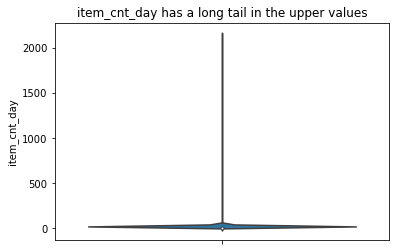

In [7]:
# plot item_cnt_day
sns.violinplot(y = train['item_cnt_day']).set(title='item_cnt_day has a long tail in the upper values')

In [8]:
print(train.sort_values(by=['item_cnt_day']).head(5),train.sort_values(by=['item_cnt_day']).tail(5))

               date  date_block_num  shop_id  item_id   item_price  \
1057907  02.11.2013              10       12     8023    15.000000   
1835454  10.07.2014              18       14    20949     5.000000   
2048519  10.10.2014              21       12     9242  1433.333333   
59156    18.01.2013               0       12     1590  2599.000000   
940092   19.10.2013               9       42     3732  2599.000000   

         item_cnt_day  
1057907         -22.0  
1835454         -16.0  
2048519          -9.0  
59156            -6.0  
940092           -6.0                  date  date_block_num  shop_id  item_id   item_price  \
2608040  14.04.2015              27       12     3731  1904.548077   
2851091  30.09.2015              32       55     9249  1702.825746   
2864235  30.09.2015              32       12     9248  1692.526158   
2326930  15.01.2015              24       12    20949     4.000000   
2909818  28.10.2015              33       12    11373     0.908714   

         item_

We notice outliers with very high "item_cnt_day".

## Data Engineering

In [9]:
#In order to deal with outliers we will apply a Z-SCORE for item_cnt_day and item_price, and remove scores outside 3 Z-Scores
#we'll limit the Z score to |3| (will cover ~99.77% of area)

train['Zscore_item_cnt_day'] = (train.item_cnt_day - train.item_cnt_day.mean())/train.item_cnt_day.std(ddof=0)
train['Zscore_item_price'] = (train.item_price - train.item_price.mean())/train.item_price.std(ddof=0)

In [10]:
#Based on our analysis above we remove Outliers and "sketchy" Rows

#First we remove the 1 row with negative item_price
train = train[train['item_price'] > 0]

#removing outliers based on Z-score
train = train[(train['Zscore_item_cnt_day']<3)&(train['Zscore_item_cnt_day']>-3)]
train = train[(train['Zscore_item_price']<3)&(train['Zscore_item_price']>-3)]

#removing Zscores now that the operation is finished
train.drop(columns=['Zscore_item_cnt_day','Zscore_item_price'], axis=1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [11]:
#our estimation is restricted to november 2015, so it's convenient we organise data by months. 
#We are working with a timeseries so we'll use datetime dtype to make things easier 

train['date'] = pd.to_datetime(train['date'], format = "%d.%m.%Y" )

In [12]:
train.head(5) #updated date

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Zscore_item_cnt_day,Zscore_item_price
0,2013-01-02,0,59,22154,999.00,1.0,-0.092652,0.062520
1,2013-01-03,0,25,2552,899.00,1.0,-0.092652,0.004710
2,2013-01-05,0,25,2552,899.00,-1.0,-0.856351,0.004710
3,2013-01-06,0,25,2554,1709.05,1.0,-0.092652,0.473001
4,2013-01-15,0,25,2555,1099.00,1.0,-0.092652,0.120330


In summary, the purpose of this competition is to figure out the expected values of how much items are sold for a given shop within the period of november 2015. Hence, an easier way to frame the problem is by making the data into a **pivot table** in which given a shop, we have the count values of items that were sold over a month and organise those monthly counts by frequency. Therefore we group train data by "shop_id" and "item_id"

In [13]:
pt = pd.pivot_table(train, index = ['shop_id', 'item_id'], values = 'item_cnt_day', columns = ['date_block_num'], aggfunc = np.sum, fill_value = 0)
pt

date_block_num   0   1   2   3   4   5   6   7   8   9   ...  24  25  26  27  \
shop_id item_id                                          ...                   
0       30        0  31   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        31        0  11   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        32        6  10   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        33        3   3   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        35        1  14   0   0   0   0   0   0   0   0  ...   0   0   0   0   
...              ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
59      22154     1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        22155     0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   
        22162     0   0   0   0   0   0   0   0   0   0  ...   0   9   4   1   
        22164     0   0   0   0   0   0   0   0   0   0  ...   0   2   1   2   
        22167     0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   

date_block_num   28  29  30  31  32  33  
shop_id item_id                          
0       30        0   0   0   0   0   0  
        31        0   0   0   0   0   0  
        32        0   0   0   0   0   0  
        33        0   0   0   0   0   0  
        35        0   0   0   0   0   0  
...              ..  ..  ..  ..  ..  ..  
59      22154     0   0   0   0   0   0  
        22155     0   0   0   0   0   0  
        22162     1   0   0   1   0   0  
        22164     0   0   1   0   0   0  
        22167     0   0   0   0   0   0  

[419159 rows x 34 columns]

In [14]:
#we currently have MultiIndex from the pivot table we built
#It's easier if we convert pt to a plain DataFrame by resetting the index with reset_index which removes the MultiIndex
pt.reset_index(inplace = True)

In [15]:
pt.tail(5)

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
419154,59,22154,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
419155,59,22155,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
419156,59,22162,0,0,0,0,0,0,0,0,...,0,9,4,1,1,0,0,1,0,0
419157,59,22164,0,0,0,0,0,0,0,0,...,0,2,1,2,0,0,1,0,0,0
419158,59,22167,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#now that we have item data, we merge the pivot table with the test data, giving priority to the latter
#as a result we keep the ordered date_block_num
df = pd.merge(test, pt, on=['shop_id', 'item_id'], how = 'left')
df.head(5)

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#as seen above we are missing values
df.fillna(0, inplace=True)
df.head(5)

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Since we completed all data engineering we finally split the data between test and train

#training data
X_train = df.drop(columns=['shop_id','item_id', 'ID', 33], axis=1) #firstly we don't need ids, not the shop & item ones, and drop the last month
y_train = df[33]

#for test we keep all the columns except the first one so we maintain the same time window as in training
X_test = df.drop(columns=['shop_id','item_id', 'ID', 0], axis=1)

In [19]:
#observing our split datasets
print('X TRAIN \n', X_train.head(3))
print('Y TRAIN \n', y_train.head(3))
print('X TEST \n', X_test.head(3))

X TRAIN 
     0    1    2    3    4    5    6    7    8    9   ...   23   24   25   26  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  2.0  2.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    27   28   29   30   31   32  
0  0.0  1.0  1.0  1.0  3.0  1.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  3.0  2.0  0.0  1.0  3.0  

[3 rows x 33 columns]
Y TRAIN 
 0    0.0
1    0.0
2    1.0
Name: 33, dtype: float64
X TEST 
     1    2    3    4    5    6    7    8    9    10  ...   24   25   26   27  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  2.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    28   29   30   31   32   33  
0  1.0  1.0  1.0  3.0  1.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  3.0  2.0  0.0

Naturally X_test has different column names than X_train since they are a month apart, but in order to fit the model, we'll change X_test to have the same column names as X_train (as if sliding an imaginary time window)

In [20]:
X_test.columns = X_train.columns

In [21]:
X_test.head(5) #artificial column names addded

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## XGBoost Regression

In [22]:
# create an xgboost regression model
model = XGBRegressor() #first we try the model with default parameters, our relevant evaluation metric is rmse (default)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.975 (0.045)


### Hyperparameter tunning

Using RandomizedSearchCV, we run a random search with a grid. Although relatively computer intensive to run, we aim to obtain better parameters aiming to improve the RMSE we've got with the default parameters.

In [23]:
"""
CODE BELOW TAKES UP TO 2 HOURS TO RUN, SKIP THIS CELL FOR RESULTS

regressor = model

hyperparameter_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_root_mean_squared_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv.fit(X_train,y_train)

random_cv.best_estimator_
"""

"\nCODE BELOW TAKES UP TO 2 HOURS TO RUN, SKIP THIS CELL FOR RESULTS\n\nregressor = model\n\nhyperparameter_grid = {\n    'n_estimators': [100, 400, 800],\n    'max_depth': [3, 6, 9],\n    'learning_rate': [0.05, 0.1, 0.20],\n    'min_child_weight': [1, 10, 100]\n    }\n\n# Set up the random search with 4-fold cross validation\nrandom_cv = RandomizedSearchCV(estimator=regressor,\n            param_distributions=hyperparameter_grid,\n            cv=5, n_iter=50,\n            scoring = 'neg_root_mean_squared_error',n_jobs = 4,\n            verbose = 5, \n            return_train_score = True,\n            random_state=42)\n\nrandom_cv.fit(X_train,y_train)\n\nrandom_cv.best_estimator_\n"

In [24]:
# IMPROVED xgboost regression model
regressor = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=400, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
# evaluate model
scores = cross_val_score(regressor, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: 0.957 (0.046)


Our new Hyperparameters slightly improve the model's Mean RMSE - this means the standard deviation of the residuals (prediction errors) decreased. In simpler terms, we have a smaller average distance between the observed data values and the values predicted by our model.

## Prediction

In [25]:
#Best Regressor
Best_Regressor = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=400, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#Given the improved model, we fit our training data
Best_Regressor.fit(X_train, y_train)

# make a prediction
yhat = Best_Regressor.predict(X_test)

# summarize prediction for total number of sales
print(yhat)

[0.5187056  0.10889808 0.8260389  ... 0.10242821 0.10889808 0.10889808]


In [26]:
submission = pd.DataFrame({
            "ID": np.arange(len(yhat)),
            "item_cnt_month": yhat
    })

In [27]:
submission.head(5)

,ID,item_cnt_month
0,0,0.518706
1,1,0.108898
2,2,0.826039
3,3,0.151741
4,4,0.108898


In [28]:
submission.to_csv('../submission.csv', index=False)

## Brief Conclusion

In brief, we conducted an EDA to then clean and prepare the data for an XGBoost regressor. After doing so we ran a Randomized Search Cross Validation to obtain better hyperparameters for our final regressor model.

In this version of the notebook we remove outliers based on the Zscore: the result was barely any difference in the competition score, but with the in-sample mean RMSE improving from 4.028 (before treating outliers) to 1.633 (after) using the default XGBoost regressor... The fact the out-of-sample score remained almost the same while the in-sample score improved significantly might be a cause of overfiting. In case I ever dive into this notebook again, it might be a worthy pursuit to explore ways to improve the out-of-sample score.